<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod4/dr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod4/dr.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>

Dimensionality Reduction
---
_homl3 ch8_

- The Curse of Dimensionality
- Main Approaches for Dimensionality Reduction
- Projection
- PCA
- Random Projection
- LLE
- Other Dimensionality Reduction Techniques

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn as skl, sklearn.datasets as skds

# The Curse of Dimensionality
- problems caused by too many features for each instances
  - extremely slow to train and validate ML models on these datasets
  - very difficult to find a good solution
- Many real-world datasets have thousands even millions of features
  - but often it is possible to reduce the number of features considerably
    - this turns an intractable problem into a tractable one
    - makes it possible to plot a condensed view of a high-dimensional training set
      - in 2D or 3D spaces
    - helps gain some important insights by visually detecting patterns
      - such as clusters
- There are three popular dimensionality reduction techniques: 
  - Random projection, PCA, and locally linear embedding (LLE)

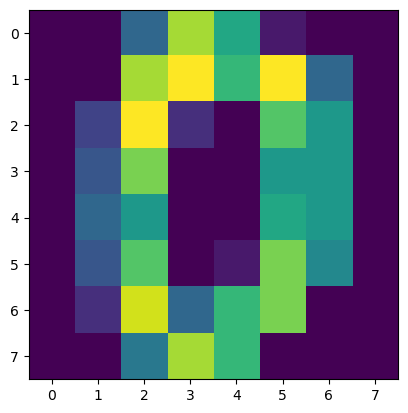

In [2]:
# 1. An example of reducing the number of features
# A compressed MNIST dataset of handwritten digits
# 
# each digit is an 8 by 8 black-white image
# 1.1 the border pixels can be dropped without losing too much information
# 1.2 the importance of each pixel can be shown with a random forest
#     two neighboring pixels are often highly correlated
#     not too much information will be lost if they were merged into a single pixel

X, y = skds.load_digits(return_X_y=True)
plt.imshow(np.reshape(X[:1],(8,8)))

## Problems Of Reducing Dimensionality
- cause some information loss
- make the ML system perform slightly worse even though it will speed up training
- make ML pipelines a bit more complex and thus harder to maintain

## An Unit [Spacelet](https://en.wikipedia.org/wiki/Hypercube) In Spaces Of Different Dimensions
| # of dimensions | spacelet with sides of 1 unit |
|:---:|:---:|
| 0 | point |
| 1 | an unit segment | 
| 2 | an unit square |
| 3 | an unit cube |
| ≥ 4 | hypercubes |

- many things behave very differently in high-dimensional space
   - the longest diagonal in a n-cube is $\sqrt{n}$
   - the [distance d(n)](https://en.wikipedia.org/wiki/Mean_line_segment_length) between two random selected points in n-cube increases when n increases
     - $d(2) \approx 0.52$
     - $d(3) \approx 0.66$
     - $d(1,000,000) \approx 370.79$
     - ∴ high-dimensional datasets are at risk of being very sparse
       - great risk of overfitting
       - new instances will likely be far away from any training instance
   - most points in a high-dimensional hypercube are very close to the border
- one solution to the curse of dimensionality could be to increase the size of the training set
  - but  the number of training instances required to reach a given density grows exponentially with the number of dimensions


# Main Approaches for Dimensionality Reduction
- Two intuitive methods
  - projection and manifold learning

## Projection
- Generally, training instances are not spread out uniformly across all dimensions
  - Many features are almost constant or highly correlated
  - ∴ all training instances lie within a much lower-dimensional subspace of the high-dimensional space

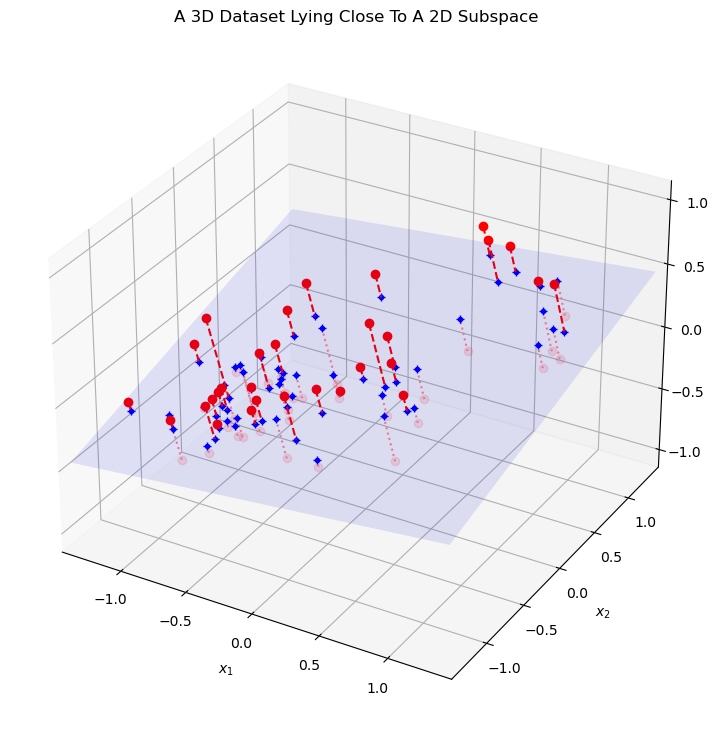

In [16]:
# 1. A 3D dataset lying close to a 2D subspace

from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axis = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axis[0], axis[1], 10),
                     np.linspace(axis[2], axis[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={'projection': '3d'})

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.1)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axis):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axis[0:2])
    ax.set_ylim(axis[2:4])
    ax.set_zlim(axis[4:6])

set_xyz_axes(ax, axis)
ax.set_title('A 3D Dataset Lying Close To A 2D Subspace')
ax.set_zticks([-1, -0.5, 0, 0.5, 1]);

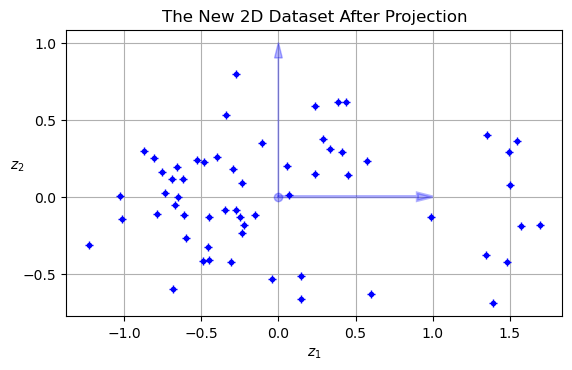

In [20]:
# 2. The new 2D dataset as one projection of the 3D dataset above
fig2, ax2 = plt.subplots(subplot_kw={'aspect': 'equal'})
ax2.plot(X2D[:, 0], X2D[:, 1], "b+")
ax2.plot(X2D[:, 0], X2D[:, 1], "b.")
ax2.plot([0], [0], "bo", alpha=0.3)
ax2.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=2, alpha=0.3)
ax2.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1, alpha=0.3)
ax2.set_xlabel("$z_1$")
ax2.set_yticks([-0.5, 0, 0.5, 1])
ax2.set_ylabel("$z_2$", rotation=0)
ax2.set_axisbelow(True)
ax2.set_title("The New 2D Dataset After Projection")
ax2.grid(True);

## Manifold Learning
- Projection is not suitable to datasets whose subspace may twist and turn
  - unrolling the subspace is preferred

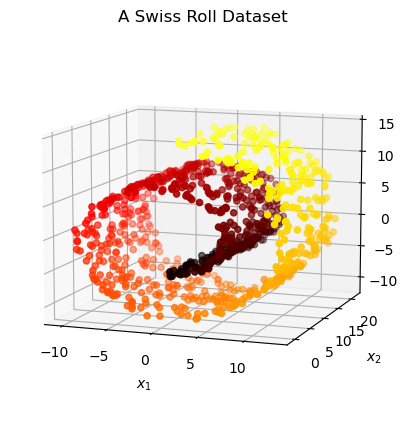

In [22]:
# 1. Swiss roll dataset
from sklearn.datasets import make_swiss_roll
from matplotlib.colors import ListedColormap

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]
fig3, ax3 = plt.subplots(figsize=(6, 5), subplot_kw={'projection':'3d'})

ax3.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax3.view_init(10, -70)
ax3.set_title('A Swiss Roll Dataset')
set_xyz_axes(ax3, axes)

- A 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space, such as
  - The Swiss roll locally resembles a 2D plane but rolls in the third dimension
- Generally,  a d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane

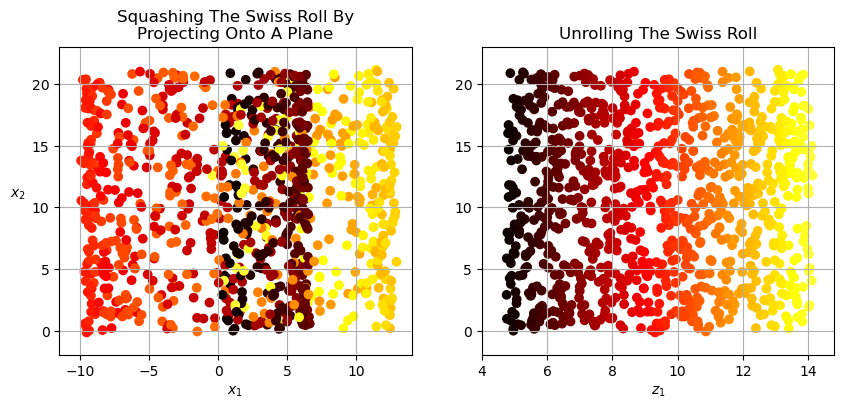

In [26]:
# 2.  unrolling the Swiss roll is preferred than  
#     Squashing by projecting onto a plane

fig4, ax4 = plt.subplots(1, 2, figsize=(10, 4))

# plt.subplot(121)
ax4[0].scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
ax4[0].axis(axes[:4])
ax4[0].set_xlabel("$x_1$")
ax4[0].set_ylabel("$x_2$", labelpad=10, rotation=0)
ax4[0].grid(True)
ax4[0].set_title('Squashing The Swiss Roll By\nProjecting Onto A Plane')

# plt.subplot(122)
ax4[1].scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
ax4[1].axis([4, 14.8, axes[2], axes[3]])
ax4[1].set_xlabel("$z_1$")
ax4[1].set_title('Unrolling The Swiss Roll')
ax4[1].grid(True);

- Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie
  - this is called `manifold learning`
- It relies on two assumptions:
   1. the ` manifold assumption`, also called ` manifold hypothesis`
       - most real-world high-dimensional datasets lie close to a much lower-dimensional manifold
   2. an implicit assumption that the ML task will be simpler if expressed in the lower-dimensional space of the manifold
       - this assumption does not always hold

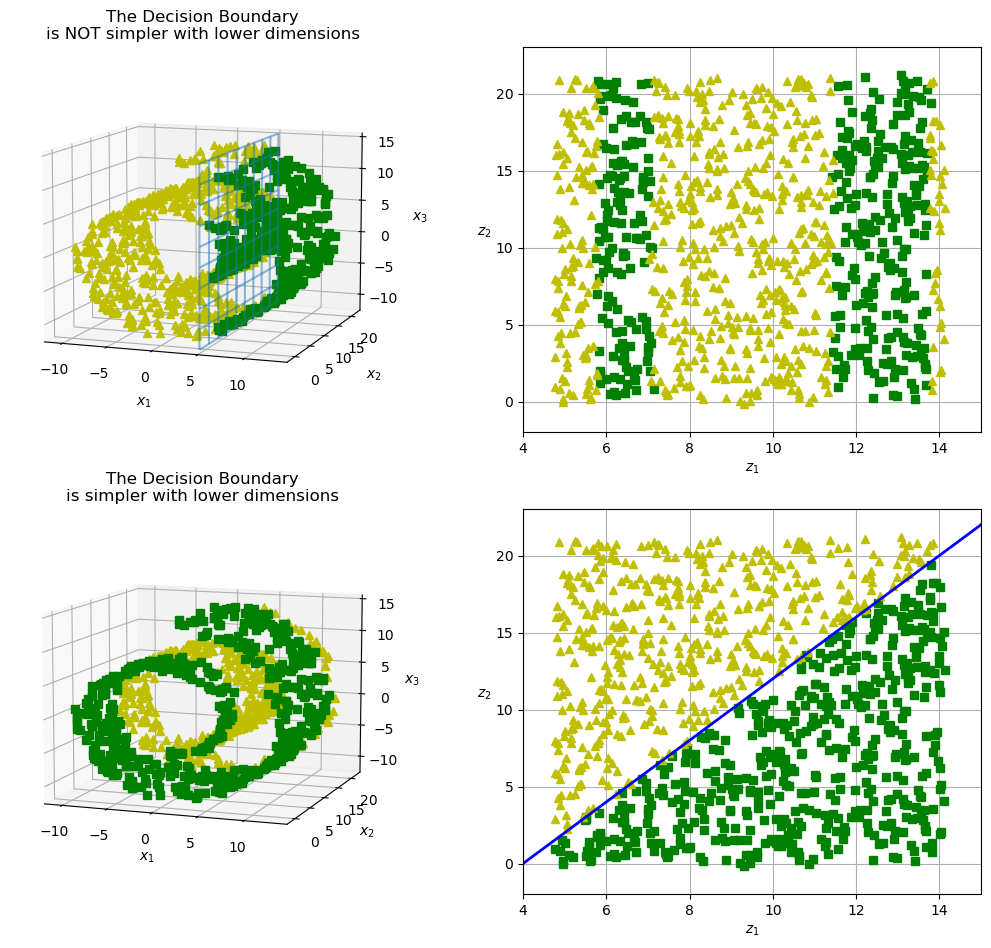

In [31]:
# 3. The implicit assumption above does NOT always hold

axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig5 = plt.figure(figsize=(13, 11))
ax51 = plt.subplot(2, 2, 1, projection='3d')
ax51.view_init(10, -70)
ax51.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax51.plot_wireframe(5, x2, x3, alpha=0.5)
ax51.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax51.set_title('The Decision Boundary\nis NOT simpler with lower dimensions')
set_xyz_axes(ax51, axes)

ax52 = plt.subplot(2, 2, 2)
ax52.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax52.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax52.axis([4, 15, axes[2], axes[3]])
ax52.set_xlabel("$z_1$")
ax52.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax52.grid(True)


positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]


ax53 = plt.subplot(2, 2, 3, projection='3d')
ax53.view_init(10, -70)
ax53.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax53.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax53.xaxis.set_rotate_label(False)
ax53.yaxis.set_rotate_label(False)
ax53.zaxis.set_rotate_label(False)
ax53.set_xlabel("$x_1$", rotation=0)
ax53.set_ylabel("$x_2$", rotation=0)
ax53.set_zlabel("$x_3$", rotation=0)
ax53.set_xlim(axes[0:2])
ax53.set_ylim(axes[2:4])
ax53.set_zlim(axes[4:6])
ax53.set_title('The Decision Boundary\nis simpler with lower dimensions')


ax54 = plt.subplot(2, 2, 4)
ax54.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax54.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax54.plot([4, 15], [0, 22], "b-", linewidth=2)
ax54.axis([4, 15, axes[2], axes[3]])
ax54.set_xlabel("$z_1$")
ax54.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax54.grid(True)

# PCA
- short for `Principal Component Analysis`
- the most popular dimensionality reduction algorithm by far
- It identifies the hyperplane that lies closest to the data, 
  - then projects the data onto it

## Preserving the Variance
- choose the right hyperplane to preserve the most variance of the dataset
  - i.e. lose least information
- The chosen axis minimizes the mean squared distance between the original dataset and its projection

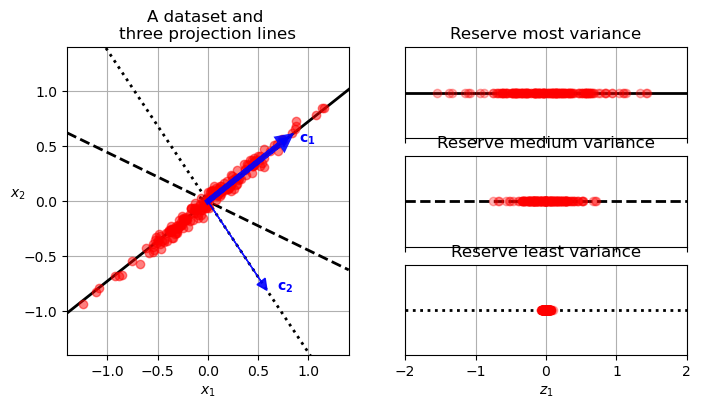

In [35]:
# 1. preserve the variance

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

fig6 = plt.figure(figsize=(8, 4))

ax6l = plt.subplot2grid((3, 2), (0, 0), rowspan=3)
ax6l.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
ax6l.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
ax6l.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
ax6l.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
ax6l.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
ax6l.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
ax6l.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
ax6l.set_xlabel("$x_1$")
ax6l.set_ylabel("$x_2$", rotation=0)
ax6l.axis([-1.4, 1.4, -1.4, 1.4])
ax6l.grid()
ax6l.set_title('A dataset and \nthree projection lines')

ax6r1 = plt.subplot2grid((3, 2), (0, 1))
ax6r1.plot([-2, 2], [0, 0], "k-", linewidth=2)
ax6r1.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
ax6r1.set_yticks([])
ax6r1.set_xticklabels([])
ax6r1.axis([-2, 2, -1, 1])
ax6r1.grid()
ax6r1.set_title('Reserve most variance')

ax6r2 = plt.subplot2grid((3, 2), (1, 1))
ax6r2.plot([-2, 2], [0, 0], "k--", linewidth=2)
ax6r2.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
ax6r2.set_yticks([])
ax6r2.set_xticklabels([])
ax6r2.axis([-2, 2, -1, 1])
ax6r2.grid()
ax6r2.set_title('Reserve medium variance')

ax6r3 = plt.subplot2grid((3, 2), (2, 1))
ax6r3.plot([-2, 2], [0, 0], "k:", linewidth=2)
ax6r3.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
ax6r3.set_yticks([])
ax6r3.axis([-2, 2, -1, 1])
ax6r3.set_xlabel("$z_1$")
ax6r3.grid()
ax6r3.set_title('Reserve least variance');


## Principal Components
- `PCA` identifies the axis that reserves the largest amount of variance in the training set
  - the blue arrow `c1` above
- then it finds a second axis, orthogonal to the first one, that reserves the largest amount of the remaining variance
  - the blue arrow `c2` above
- The iᵗʰ axis is called the iᵗʰ `principal component (PC)` of the dataset
  - the number of PCs equals the number of dimensions in the dataset
- The PCs of a dataset can be found with `singular value decomposition (SVD)`
  - SVD is a standard matrix factorization technique 
  - ${\displaystyle \ \mathbf {M} =\mathbf {U\Sigma V^{T}} }$
  - $\mathbf{V=(c_1,c_2,\cdots,c_m)}$ is the `principal components matrix`

In [38]:
# 1. Find the PCs of dataset X at the beginning of the notebook

# Center the dataset around the origin before PCA
X_centered = X - X.mean(axis=0)

U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]
c3 = Vt[2]
c1,c2,c3

(array([0.67857588, 0.70073508, 0.22023881]),
 array([-0.72817329,  0.6811147 ,  0.07646185]),
 array([-0.09642839, -0.21225719,  0.97244458]))

In [43]:
# 2. construct Σ from s
n, m = X.shape
Σ = np.zeros_like(X_centered)
Σ[:m, :m] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)
diag = np.min([n,m])
Σ[:diag, :diag]

array([[5.93449971, 0.        , 0.        ],
       [0.        , 2.65661127, 0.        ],
       [0.        , 0.        , 2.04831319]])


## Projecting Down to d Dimensions
- With all the PCs, we can reduce the dimensionality of the dataset $\mathbf{X}$ down to d dimensions 
  - by projecting it onto the hyperplane defined by the first d PCs $\mathbf{W_d}$
  - this hyperplane ensures the projection $\mathbf{X_{d-proj}}$ will preserve as much variance as possible
  - $\mathbf{X_{d-proj} = XW_d}$


In [44]:
# 3. project X to 2D
W2 = Vt[:2].T
X2D = X_centered @ W2
X2D.shape

(60, 2)


## Using Scikit-Learn



## Explained Variance Ratio



## Choosing the Right Number of Dimensions



## PCA for Compression



## Randomized PCA



## Incremental PCA



# Random Projection



# LLE



# Other Dimensionality Reduction Techniques